# Methods Writeup

In [78]:
import sys
import os
from os.path import join as j
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

project_root = os.path.abspath('../')

# Segmentation Threshold

### Load Data

In [79]:
import sqlite3
conn_cv = sqlite3.connect(j(project_root,'data','interm','cv2_threshold0.2_lengths.sqlite'))

res = conn_cv.execute("SELECT name FROM sqlite_master WHERE type='table';")

print("Tables: %s"%(res.fetchall()))

Tables: [('vein_lengths',)]


In [80]:
import pandas as pd
import sqlite3
import warnings

conn_man = sqlite3.connect('../reports/data/results.sqlite')

df_data = pd.read_sql("SELECT * FROM vein_lengths",conn_cv)
# df_train = pd.read_sql("SELECT * FROM v3_train_vein_length",conn)
df_human = pd.read_sql("SELECT * FROM manually_measured",conn_man)

In [81]:
R = np.zeros((3,8))
R[:] = np.nan
for i,cv in enumerate(['0','1','2']):
    for k,threshold in enumerate(['0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9']):
        if cv == '1' and threshold == '0.5':
            continue
        conn_cv = sqlite3.connect(j(project_root,'data','interm','cv' + cv + '_threshold' + threshold + '_lengths.sqlite'))
        df_data = pd.read_sql("SELECT * FROM vein_lengths",conn_cv)

        df_data_merged = df_data.merge(df_human[['plant','replicate','length']],
                               on=["plant","replicate"],
                               how="inner",
                               suffixes=("_measured","_human"),
                               validate="one_to_one")

        R[i,k] =  df_data_merged[['length_measured','length_human']].corr()['length_measured'][1]
    



### Plot data

Text(0.5, 0, 'Segmentation Threshold')

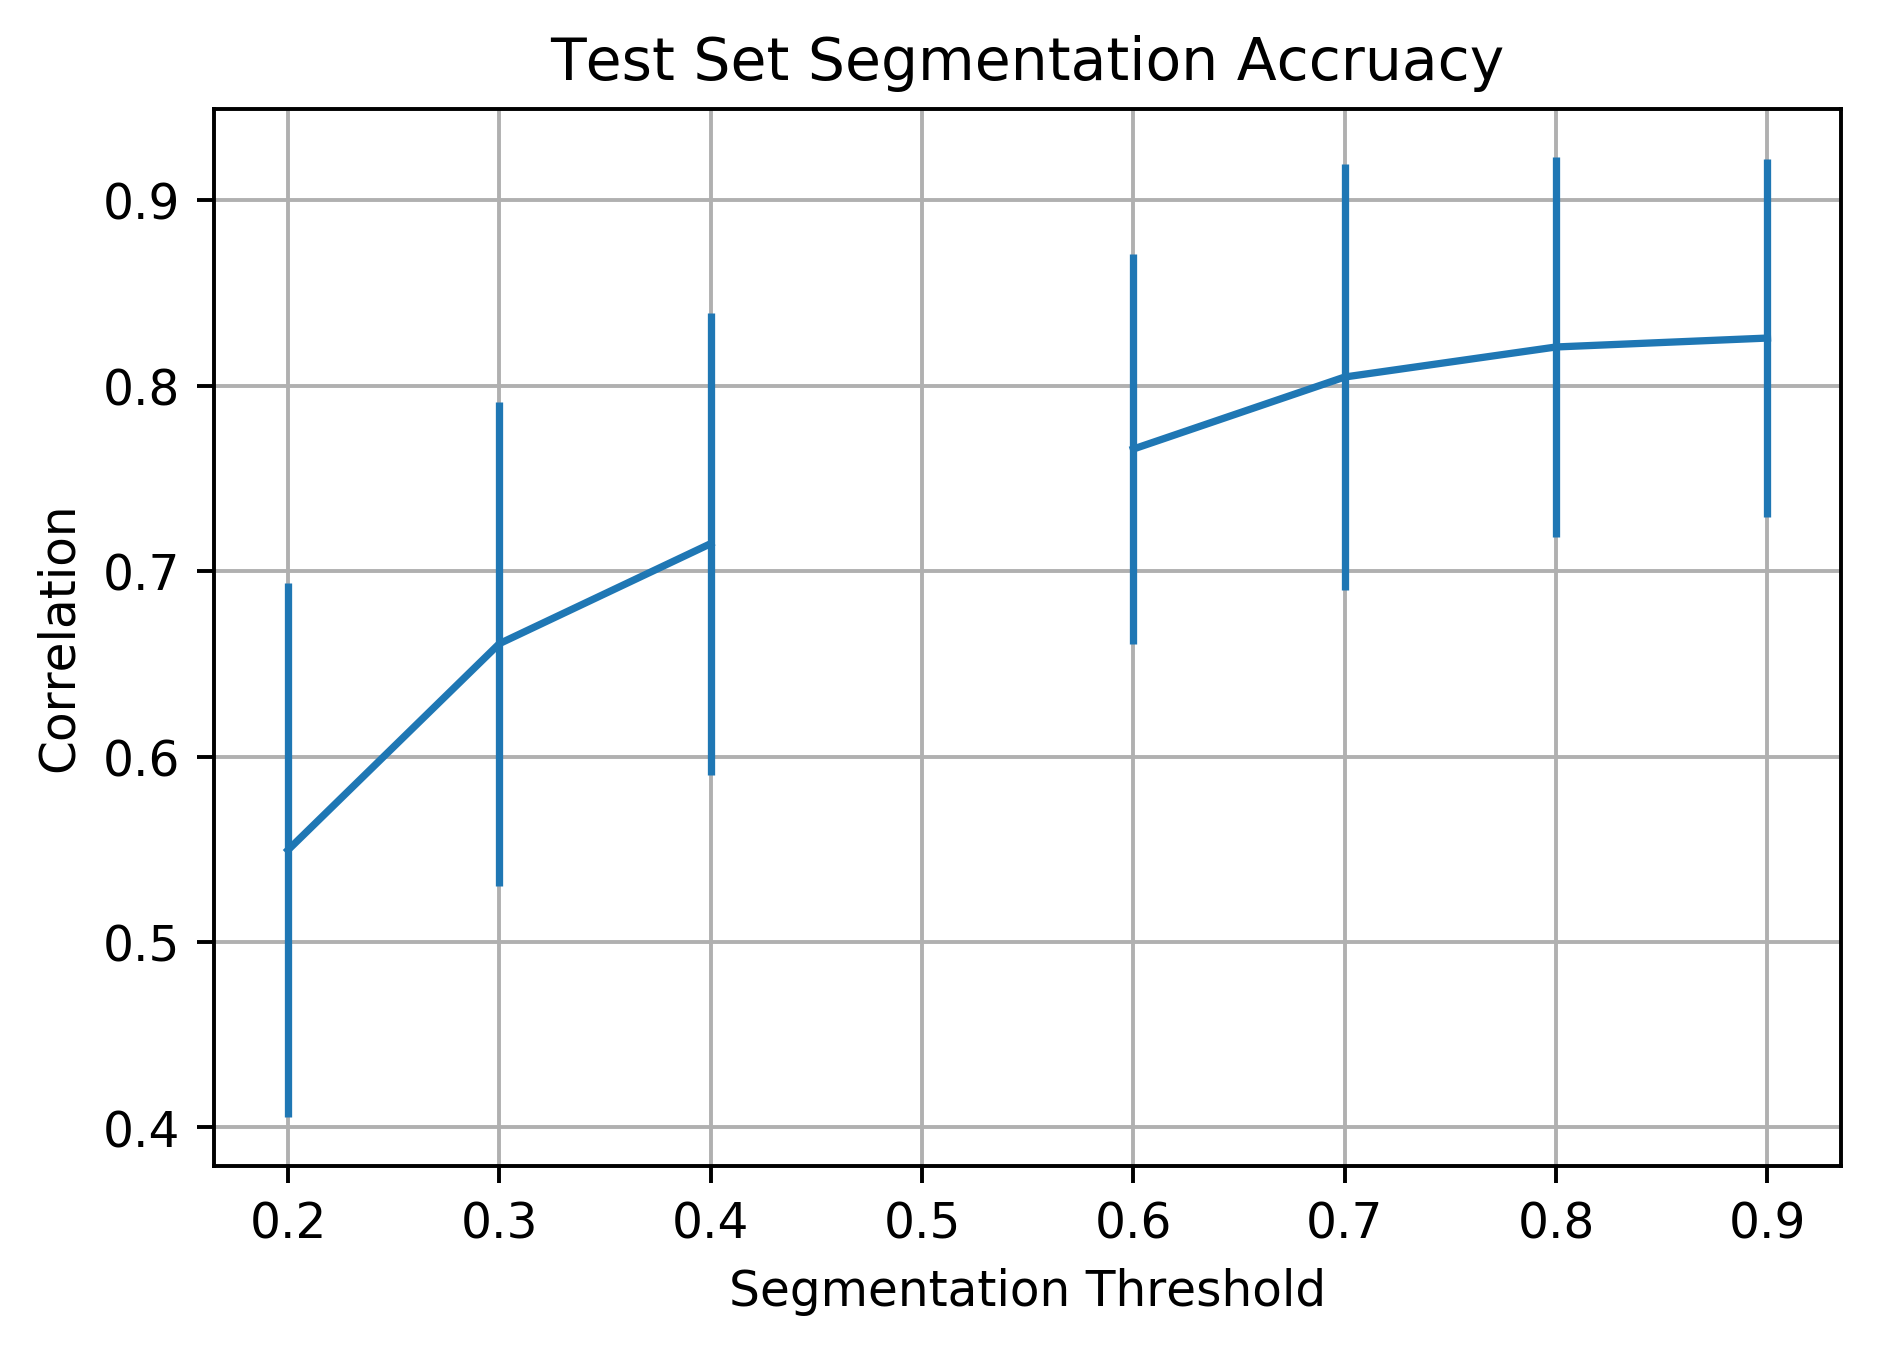

In [65]:
plt.figure(dpi=350)
plt.errorbar([0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],R.mean(axis=0),R.std(axis=0))
plt.grid()
plt.title("Test Set Segmentation Accruacy")
plt.ylabel("Correlation")
plt.xlabel("Segmentation Threshold")

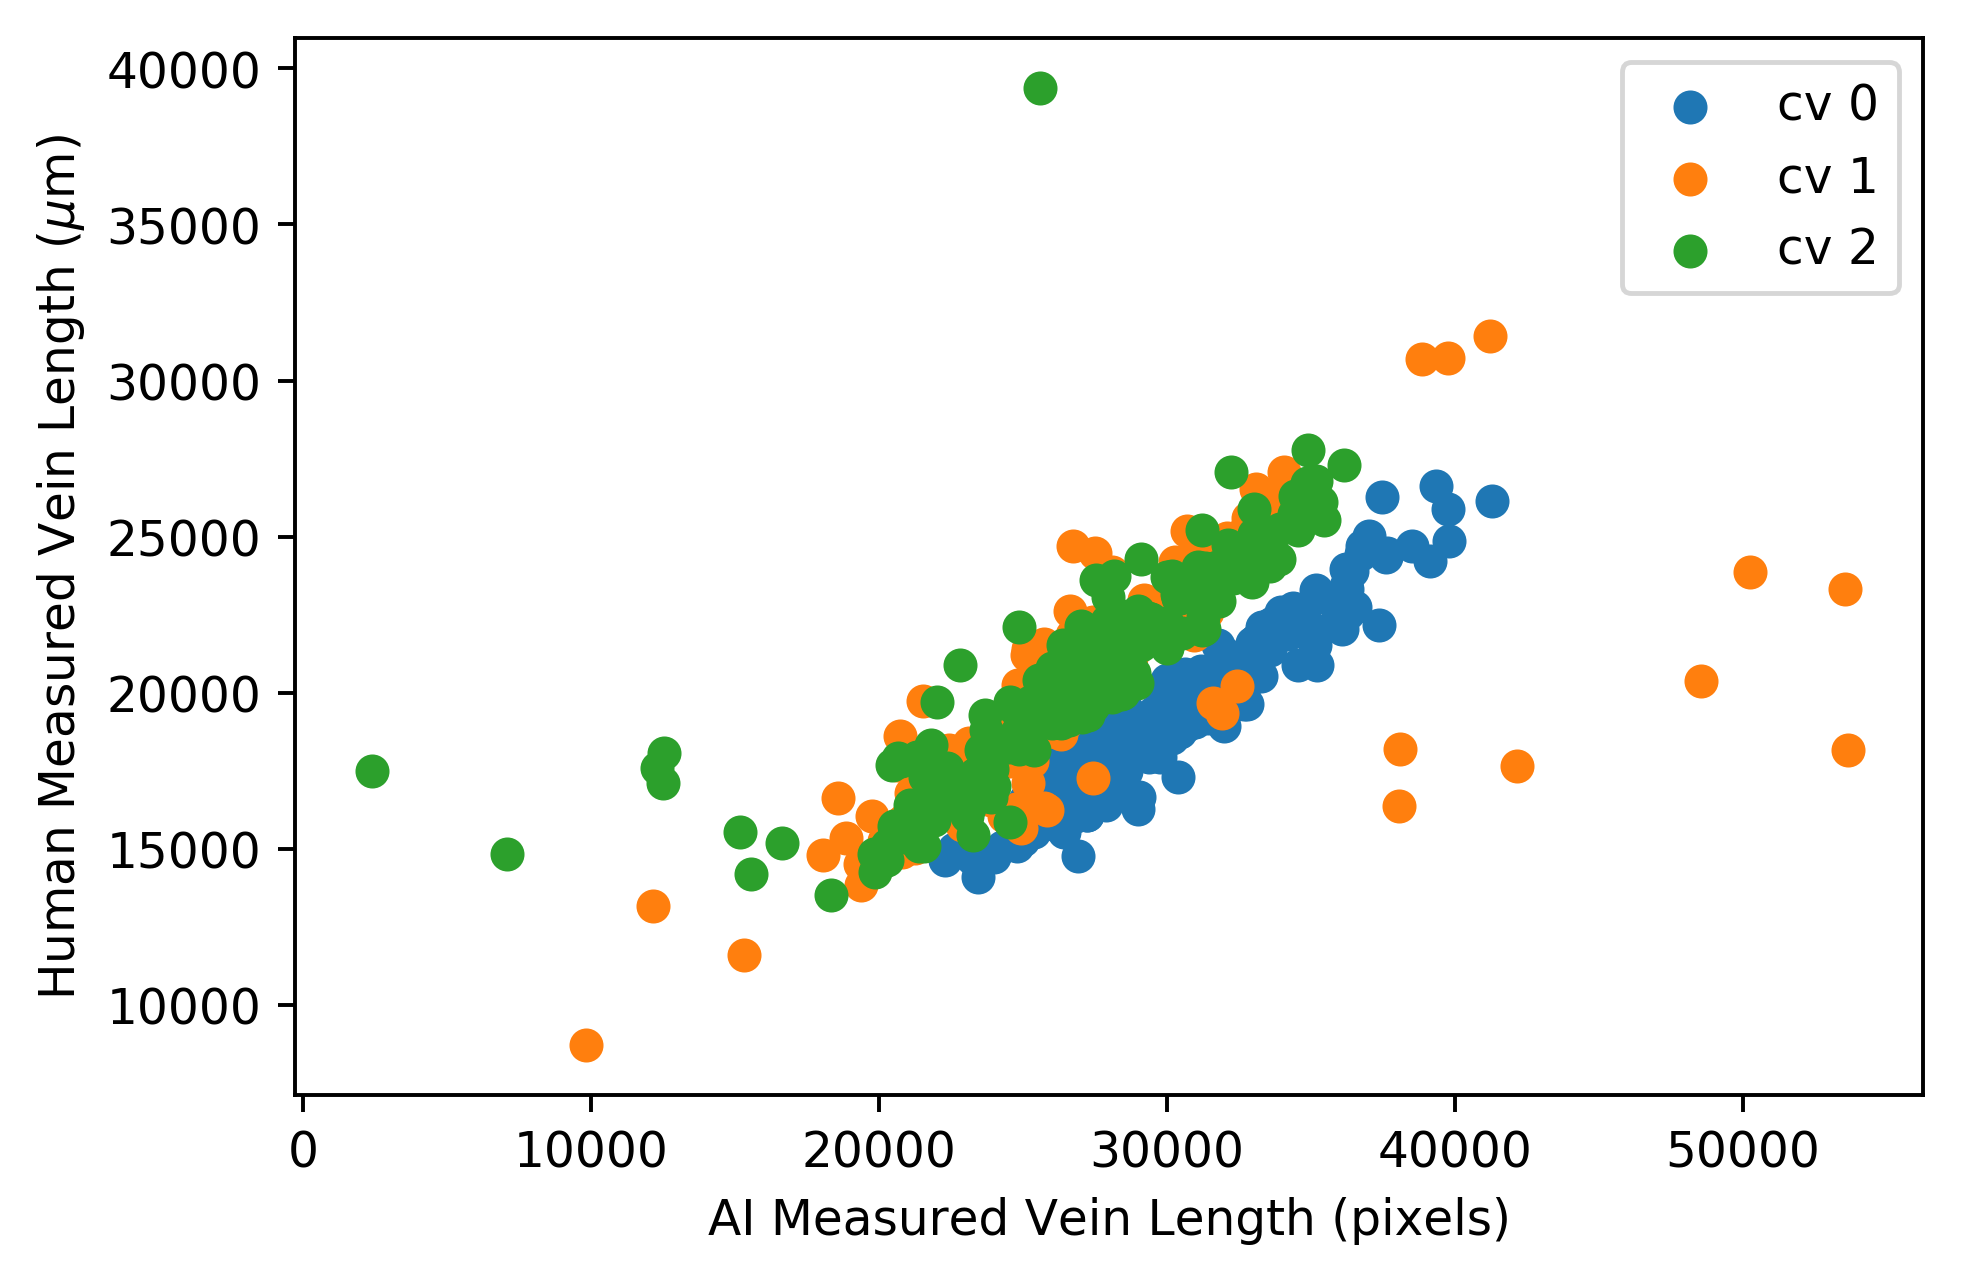

In [83]:
plt.figure(dpi=350)

def plot_scatter(df, label=None):
    if df[['length_measured','length_human']].isna().values.any():
        warnings.warn("NA values detected, they will be dropped")
        df = df.dropna()

    #Plot Scatter data
    plt.scatter(df['length_measured'],df['length_human'],label=label)
    plt.xlabel('AI Measured Vein Length (pixels)')
    plt.ylabel(r'Human Measured Vein Length ($\mu$m)')

for i,cv in enumerate(['0','1','2']):
    threshold = '0.9'
    conn_cv = sqlite3.connect(j(project_root,'data','interm','cv' + cv + '_threshold' + threshold + '_lengths.sqlite'))
    df_data = pd.read_sql("SELECT * FROM vein_lengths",conn_cv)

    df_data_merged = df_data.merge(df_human[['plant','replicate','length']],
                           on=["plant","replicate"],
                           how="inner",
                           suffixes=("_measured","_human"),
                           validate="one_to_one")
    
    plot_scatter(df_data_merged,label="cv %s"%(cv))
    plt.legend()

In [7]:
outliers_idx = np.where(error**2 > (std**2 * 3))

print(r"Outliers with an error greater than %0.0f:"%(std * 3,))
outliers = df_all_merged.iloc[outliers_idx].copy()
outliers['error'] = error.iloc[outliers_idx]
outliers[['plant','replicate','length_measured','length_human','error']]

NameError: name 'error' is not defined

## Fit a linear model to the data to find outliers.

To get an idea of how much the error is in micrometers, I fit a linear model to the data and used it to convert AI measured vein length to micromenters.

In [ ]:
from sklearn.linear_model import LinearRegression
from IPython.display import display, Latex

reg = LinearRegression().fit(df_all_merged['length_measured'].values.reshape(-1,1),
                           df_all_merged['length_human'])

display(Latex(r"Model estimated $%0.1f$ $pixels/ \mu m$"%(reg.intercept_)))

preds = reg.predict(error.values.reshape(-1,1))

plt.hist(preds,50);
plt.xlabel(r'Error ($\mu m$)')
plt.ylabel('Count')

std = np.std(preds)
plt.annotate(r"$\sigma = %0.0f$ $\mu m$"%(std,), 
             xy=(0.05, 0.85), 
             xycoords='axes fraction');